# Проект "Телеком"

## Задача

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## План решения задачи



1) Объединить данные в один датафрейм, привести данные к нужному типу, добавить столбцы с индикатором того является ли абонент пользователем интернета или телефонии

2) В отдельном столбце вычислить для каждого пользователя срок пользования услугами компании в днях. Если абонент не покинул компанию - срок рассчитывается от начала пользования услугами до 1 февраля 2020 года, если покинул - с даты начала пользования до даты ухода.

3) Добавить столбец с таргетом: класс "1" если абонент перестал пользоваться услугами (EndDate есть), класс "0" - если не перестал пользоваться (EndDate нет). Столбец "EndDate" удалить.

4) Выбрать наиболее значимые для машинного обучения признаки, поработать с мультиколлинеарностью.

4) Разбить данные на обучающую и тестовую выборку, обучить модели классификации учитывая баланс классов. Варианты моделей - случайный лес, логистическая регрессия, градиентный спуск.

5) Выбрать модель с наименьшей функцией потерь на обучающей выборке, обучить выбранную модель на обучающей выборке.

6) При условии если модель покажет хорошие результаты (roc-auc > 0.85) - оставить в датафрейме только признаки с данными об услугах, которыми пользуется абонент и время пользования услугами компании, обучить модель на усеченных данных и найти лучшую модель.

## Предобработка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_classif as MIC
import lightgbm as lgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

Загрузим исходные данные.

In [2]:
contract = pd.read_csv('contract.csv')
internet = pd.read_csv('internet.csv')
personal = pd.read_csv('personal.csv')
phone = pd.read_csv('phone.csv')

Первая таблица - "contract".

In [3]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


В таблице "contract" собраны данные о времени "жизни" абонента, типе оплаты, способах рассчета и количестве ежемесячных/общих затратах на услуги.

- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – безналичный расчет,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги.

In [4]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


Приведем данные к нужному типу

In [5]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [6]:
contract['EndDate'] = contract['EndDate'].replace('No', np.nan)

In [7]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format = '%Y-%m-%d')

In [8]:
contract['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

Заменим отсутствующие значения в "TotalCharges" на "0".

In [9]:
contract['TotalCharges'] = contract['TotalCharges'].replace(
    contract['TotalCharges'].value_counts().reset_index()['index'][0], 0)

In [10]:
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

Удалим столбцы о способах оплаты, так как они не несут в себе значимой информации.

In [11]:
contract = contract.drop('PaperlessBilling', axis = 1)
contract = contract.drop('PaymentMethod', axis = 1)

Следующая таблица - "internet".

In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


В таблице "internet" собраны данные о пользователях интернета:

Тип подключения: 
- через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») 
- оптоволоконный кабель (*Fiber optic*).  

И доп. услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

In [13]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


Закодируем данные: 'Yes': 1, 'No': 0.

In [14]:
internet = internet.replace('Yes', 1)
internet = internet.replace('No', 0)
internet['InternetUser'] = 1
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,InternetUser
0,7590-VHVEG,DSL,0,1,0,0,0,0,1
1,5575-GNVDE,DSL,1,0,1,0,0,0,1
2,3668-QPYBK,DSL,1,1,0,0,0,0,1
3,7795-CFOCW,DSL,1,0,1,1,0,0,1
4,9237-HQITU,Fiber optic,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,1,0,1,1,1,1,1
5513,2234-XADUH,Fiber optic,0,1,1,0,1,1,1
5514,4801-JZAZL,DSL,1,0,0,0,0,0,1
5515,8361-LTMKD,Fiber optic,0,0,0,0,0,0,1


In [15]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


В следующей таблице "personal" собраны личные данные о пользователях:
- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)

In [16]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


Закодируем данные:

In [17]:
personal = personal.replace('Female', 0)
personal = personal.replace('Male', 1)
personal = personal.replace('No', 0)
personal = personal.replace('Yes', 1)
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0
...,...,...,...,...,...
7038,6840-RESVB,1,0,1,1
7039,2234-XADUH,0,0,1,1
7040,4801-JZAZL,0,0,1,1
7041,8361-LTMKD,1,1,1,0


In [18]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В следующей таблице "phone" собраны данные о доп. услугах пользователей телефона:
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

In [19]:
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [20]:
phone = phone.replace('Yes', 1)
phone = phone.replace('No', 0)
phone['PhoneUser'] = 1
phone

,customerID,MultipleLines,PhoneUser
0,5575-GNVDE,0,1
1,3668-QPYBK,0,1
2,9237-HQITU,0,1
3,9305-CDSKC,1,1
4,1452-KIOVK,1,1
...,...,...,...
6356,2569-WGERO,0,1
6357,6840-RESVB,1,1
6358,2234-XADUH,1,1
6359,8361-LTMKD,1,1


Объединим данные в один датафрейм по столбцу 'customerID'.

In [21]:
df = pd.merge(contract, internet, on = 'customerID', how = 'left')
df = pd.merge(df, personal, on = 'customerID', how = 'left')
df = pd.merge(df, phone, on = 'customerID', how = 'left')

In [22]:
df

,customerID,BeginDate,EndDate,Type,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,InternetUser,gender,SeniorCitizen,Partner,Dependents,MultipleLines,PhoneUser
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,29.85,29.85,DSL,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0,NaN,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,56.95,1889.50,DSL,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0,0,0.0,1.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,53.85,108.15,DSL,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0.0,1.0
3,7795-CFOCW,2016-05-01,NaT,One year,42.30,1840.75,DSL,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1,0,0,0,NaN,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,70.70,151.65,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,84.80,1990.50,DSL,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1,0,1,1,1.0,1.0
7039,2234-XADUH,2014-02-01,NaT,One year,103.20,7362.90,Fiber optic,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0,1,1,1.0,1.0
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,29.60,346.45,DSL,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,1,NaN,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,74.40,306.60,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,0,1.0,1.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   MonthlyCharges    7043 non-null   float64       
 5   TotalCharges      7043 non-null   float64       
 6   InternetService   5517 non-null   object        
 7   OnlineSecurity    5517 non-null   float64       
 8   OnlineBackup      5517 non-null   float64       
 9   DeviceProtection  5517 non-null   float64       
 10  TechSupport       5517 non-null   float64       
 11  StreamingTV       5517 non-null   float64       
 12  StreamingMovies   5517 non-null   float64       
 13  InternetUser      5517 non-null   float64       
 14  gender            7043 n

Недостающие данные о доп. услугах заполним нулем - "0" (не пользуется услугой).

In [24]:
df[df.columns[6:]] = df[df.columns[6:]].fillna(0)

In [25]:
df[df.columns[7:]] = df[df.columns[7:]].astype(int)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   MonthlyCharges    7043 non-null   float64       
 5   TotalCharges      7043 non-null   float64       
 6   InternetService   7043 non-null   object        
 7   OnlineSecurity    7043 non-null   int64         
 8   OnlineBackup      7043 non-null   int64         
 9   DeviceProtection  7043 non-null   int64         
 10  TechSupport       7043 non-null   int64         
 11  StreamingTV       7043 non-null   int64         
 12  StreamingMovies   7043 non-null   int64         
 13  InternetUser      7043 non-null   int64         
 14  gender            7043 n

## Построение моделей

Таргетом будет служить наличие или отсутствие данных в столбце "EndDate". Выведем эту информацию в отдельный столбец.

In [27]:
df['Target'] = (-df['EndDate'].isna()).astype(int)

Посчитаем срок жизни абонента и выведем получившееся число в отдельный признак. Столбцы "EndDate" и "BeginDate" удалим.

In [28]:
df['EndDate'] = df['EndDate'].fillna('2020-02-01')
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['Duration'] = (df['EndDate'] - df['BeginDate']).dt.days
df = df.drop('EndDate', axis = 1)
df = df.drop('BeginDate', axis = 1)

Применим One Hot кодирование к категориальным признакам.

In [29]:
types = pd.get_dummies(df['Type'], drop_first = True)
InternetService = pd.get_dummies(df['InternetService'], drop_first = True)
df = df.join(types)
df = df.join(InternetService)
df = df.drop('Type', axis = 1)
df = df.drop('InternetService', axis = 1)

Признак 'customerID' удалим, так как он не несет значимой ценности для обучения моделей.

In [30]:
df = df.drop('customerID', axis = 1)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MonthlyCharges    7043 non-null   float64
 1   TotalCharges      7043 non-null   float64
 2   OnlineSecurity    7043 non-null   int64  
 3   OnlineBackup      7043 non-null   int64  
 4   DeviceProtection  7043 non-null   int64  
 5   TechSupport       7043 non-null   int64  
 6   StreamingTV       7043 non-null   int64  
 7   StreamingMovies   7043 non-null   int64  
 8   InternetUser      7043 non-null   int64  
 9   gender            7043 non-null   int64  
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   int64  
 12  Dependents        7043 non-null   int64  
 13  MultipleLines     7043 non-null   int64  
 14  PhoneUser         7043 non-null   int64  
 15  Target            7043 non-null   int64  
 16  Duration          7043 non-null   int64  


In [32]:
df.head(3)

,MonthlyCharges,TotalCharges,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,InternetUser,gender,...,Partner,Dependents,MultipleLines,PhoneUser,Target,Duration,One year,Two year,DSL,Fiber optic
0,29.85,29.85,0,1,0,0,0,0,1,0,...,1,0,0,0,0,31,0,0,1,0
1,56.95,1889.50,1,0,1,0,0,0,1,1,...,0,0,0,1,0,1036,1,0,1,0
2,53.85,108.15,1,1,0,0,0,0,1,1,...,0,0,0,1,1,61,0,0,1,0


Разобьем датафрейм на обучающую и тестовую выборки, выведем признаки и таргет в отдельные датафреймы.

In [33]:
train, test = train_test_split(df, test_size = 0.25, random_state = 111111)

In [34]:
features_train = train.drop('Target', axis = 1)
target_train = train['Target']
features_test = test.drop('Target', axis = 1)
target_test = test['Target']

### Мультиколлинеарность и отбор признаков

Найдем корреляцию количественных признаков между собой

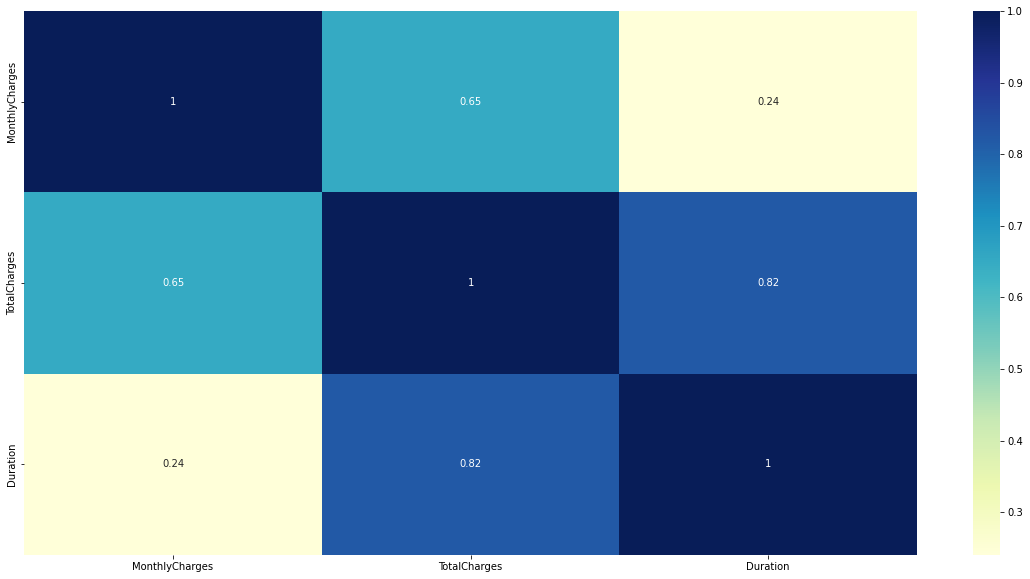

In [35]:
plt.figure(figsize = (20, 10))
dataplot = sns.heatmap(features_train[['MonthlyCharges', 'TotalCharges', 'Duration']].corr(), cmap="YlGnBu", annot=True)

In [36]:
vif_data = pd.DataFrame()
vif_data["feature"] = features_train[['MonthlyCharges', 'TotalCharges', 'Duration']].columns
vif_data["VIF"] = [variance_inflation_factor(features_train[['MonthlyCharges', 'TotalCharges', 'Duration']].values, i)
                          for i in range(len(features_train[['MonthlyCharges', 'TotalCharges', 'Duration']].columns))]
  
vif_data

,feature,VIF
0,MonthlyCharges,3.362727
1,TotalCharges,7.939321
2,Duration,6.172381


Все количественные признаки сильно коррелируют между собой. Действительно можно предположить, что чем дольше абонент пользуется услугами, тем больше денег он потратил и чем больше ежемесячный платеж, и тем больше общая сумма затрат на пользование услугами. Найдем наиболее значимый для определения таргета признак методом оценки mutual information и уберем наименее значимые признаки.

In [37]:
MIC_data = pd.DataFrame({'feature' : list(features_train[['MonthlyCharges', 'TotalCharges', 'Duration']].columns),
                         'MIC' : list(MIC(features_train[['MonthlyCharges', 'TotalCharges', 'Duration']], target_train))})
MIC_data = MIC_data.sort_values('MIC', ascending = False)
MIC_data

,feature,MIC
2,Duration,0.316631
0,MonthlyCharges,0.048865
1,TotalCharges,0.040506


In [38]:
features_train = features_train.drop(['MonthlyCharges', 'TotalCharges'], axis = 1)
features_test = features_test.drop(['MonthlyCharges', 'TotalCharges'], axis = 1)

Мультиколлинеарность убрана. Теперь посмотрим на оценки значимости признаков для определения таргета.

In [39]:
MIC_data = pd.DataFrame({'feature' : list(features_train.columns), 'MIC' : list(MIC(features_train, target_train))})
MIC_data = MIC_data.sort_values('MIC', ascending = False)

<AxesSubplot:xlabel='feature'>

<Figure size 1440x720 with 0 Axes>

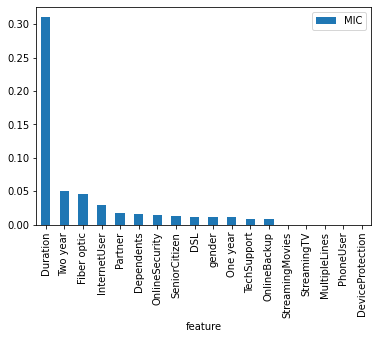

In [40]:
plt.figure(figsize = (20, 10))
MIC_data.plot(x = 'feature', y = 'MIC', kind = 'bar')

Наиболее значимый признак с большим отрывом от остальных - 'Duration'. Также признаки 'Two year' и 'Fiber optic' являются наиболее значимыми. Оставим 5 наиболее значимых признаков в датафрейтме, чтобы избежать переобучения.

In [41]:
MIC_data_cut = MIC_data[MIC_data['MIC'] > MIC_data['MIC'].quantile(0.75)]
MIC_data_cut

,feature,MIC
13,Duration,0.310379
15,Two year,0.049948
17,Fiber optic,0.045949
6,InternetUser,0.029818
9,Partner,0.017151


In [42]:
features_train = features_train[list(MIC_data_cut['feature'])]
features_test = features_test[list(MIC_data_cut['feature'])]

### Случайный лес

In [43]:
rf_model = RandomForestClassifier(class_weight = 'balanced', random_state = 12345)
rf_params = {
    'n_estimators' : list(range(10, 160, 20)),
    'max_depth' : list(range(2, 50, 5))
}
rf = GridSearchCV(rf_model, rf_params, cv = 3, scoring = 'roc_auc')
rf_best_result = rf.fit(features_train, target_train)

In [44]:
rf_best_result.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=17, n_estimators=130,
                       random_state=12345)

In [45]:
rf_predictions = rf_best_result.best_estimator_.predict_proba(features_test)[:, 1]
rf_score = roc_auc_score(target_test, rf_predictions)
rf_score

0.9077573354480571

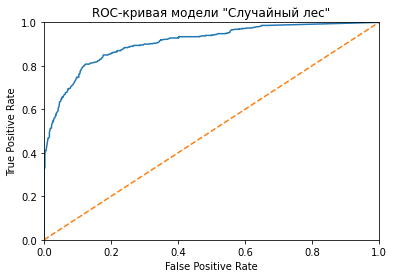

In [46]:
fpr, tpr, thresholds = roc_curve(target_test, rf_predictions)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели "Случайный лес"')


plt.show()

### Логистическая регрессия

In [47]:
lr_model = LogisticRegression(class_weight = 'balanced', random_state = 12345)
lr_model.fit(features_train, target_train)
lr_predictions = lr_model.predict_proba(features_test)[:, 1]
lr_score = roc_auc_score(target_test, lr_predictions)
lr_score

0.8307470261697065

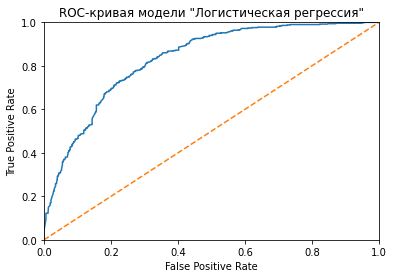

In [48]:
fpr, tpr, thresholds = roc_curve(target_test, lr_predictions)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели "Логистическая регрессия"')


plt.show()

### Градиентный бустинг

In [49]:
params = {
    'learning_rate': [0.1, 0.03, 0.001],
    'n_estimators': [400, 500, 700, 1000],
    'max_depth': [15, 20, 25],
}

In [50]:
gb = GridSearchCV(lgb.LGBMClassifier(random_state=12345), params, scoring='roc_auc', cv=3)
LGBMRegressor_best_result = gb.fit(features_train, target_train)

In [51]:
LGBMClassifier_best_result = gb.best_estimator_
LGBMClassifier_best_result

LGBMClassifier(learning_rate=0.03, max_depth=20, n_estimators=700,
               random_state=12345)

In [52]:
predictions_lgb = LGBMClassifier_best_result.predict_proba(features_test)[:, 1]

In [53]:
lgb_score = roc_auc_score(target_test, predictions_lgb)
lgb_score

0.9348025376685172

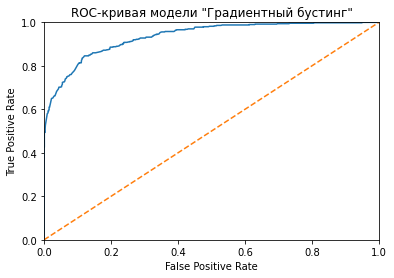

In [54]:
fpr, tpr, thresholds = roc_curve(target_test, predictions_lgb)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели "Градиентный бустинг"')


plt.show()

In [55]:
results = pd.DataFrame({
    'Случайный лес' : [rf_score.round(4)],
    'Логистическая регрессия' : [lr_score.round(4)],
    'Градиентный бустинг' : [lgb_score.round(4)]
})
results = results.rename(index = {0 : 'roc_auc'})
results

,Случайный лес,Логистическая регрессия,Градиентный бустинг
roc_auc,0.9078,0.8307,0.9348


Модели "Случайный лес" и "Градиентный бустинг" преодолели порог roc_auc > 0.85. Лучший показатель у модели "Градиентный бустинг" - roc_auc = 0.93.

## Обучение моделей с базовыми признаками

Для более стабильной работы модели в будущем будет полезно попробовать обучить модель только на основных признаках, которые не меняются у пользователей с течением времени или меняются не так быстро как остальные - это такие признаки как "пол", наличие пенсионного статуса, продолжительность пользования услугами и статуса пользования услугой "интернет" или "телефон".

In [56]:
df_basic = df[['InternetUser', 
               'gender',
               'SeniorCitizen',
               'PhoneUser',
               'Duration',
               'Target']]

In [57]:
train_basic, test_basic = train_test_split(df_basic, test_size = 0.25, random_state = 111111)
features_basic_train = train_basic.drop('Target', axis = 1)
target_basic_train = train_basic['Target']
features_basic_test = test_basic.drop('Target', axis = 1)
target_basic_test = test_basic['Target']

### Случайный лес

In [58]:
rf_best_result_basic = rf.fit(features_basic_train, target_basic_train)

In [59]:
rf_best_result_basic.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=32, n_estimators=150,
                       random_state=12345)

In [60]:
rf_predictions_basic = rf_best_result_basic.best_estimator_.predict_proba(features_basic_test)[:, 1]
rf_basic_score = roc_auc_score(target_basic_test, rf_predictions_basic)
rf_basic_score

0.8963822363203807

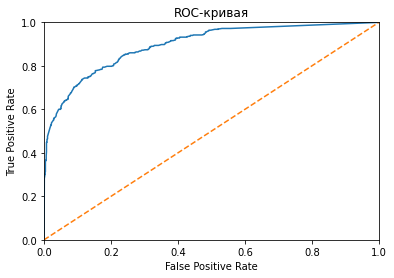

In [61]:
fpr, tpr, thresholds = roc_curve(target_basic_test, rf_predictions_basic)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')


plt.show()

### Логистическая регрессия

In [62]:
lr_model = LogisticRegression(class_weight = 'balanced', random_state = 12345)
lr_params = {
    'C': np.logspace(-4, 4, 20),
    }

lr = GridSearchCV(lr_model, lr_params, cv = 3, scoring = 'roc_auc')
lr_best_result = lr.fit(features_basic_train, target_basic_train)

In [63]:
lr_best_result.best_estimator_

LogisticRegression(C=10000.0, class_weight='balanced', random_state=12345)

In [64]:
lr_predictions = lr_best_result.best_estimator_.predict_proba(features_basic_test)[:, 1]
lr_basic_score = roc_auc_score(target_basic_test, lr_predictions)
lr_basic_score

0.8044377478191911

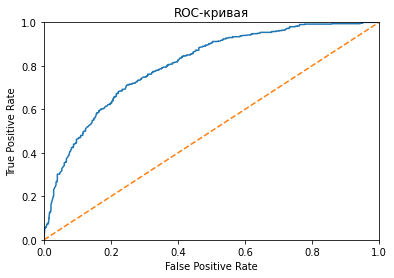

In [65]:
fpr, tpr, thresholds = roc_curve(target_basic_test, lr_predictions)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')


plt.show()

### Градиентный бустинг

In [66]:
category = list(train_basic.columns.drop('Duration'))
train_basic[category] = train_basic[category].astype('category')
test_basic[category] = test_basic[category].astype('category')
features_basic_train = train_basic.drop('Target', axis = 1)
target_basic_train = train_basic['Target']
features_basic_test = test_basic.drop('Target', axis = 1)
target_basic_test = test_basic['Target']

In [67]:
params = {
    'learning_rate': [0.1, 0.03, 0.001],
    'n_estimators': [400, 500, 700, 1000],
    'max_depth': [15, 20, 25],
}

In [68]:
gb = GridSearchCV(lgb.LGBMClassifier(random_state=12345), params, scoring='roc_auc', cv=3)
LGBMRegressor_best_result = gb.fit(features_basic_train, target_basic_train)

In [69]:
LGBMClassifier_best_result = gb.best_estimator_
LGBMClassifier_best_result

LGBMClassifier(learning_rate=0.03, max_depth=25, n_estimators=1000,
               random_state=12345)

In [70]:
predictions_lgb = LGBMClassifier_best_result.predict_proba(features_basic_test)[:, 1]

In [71]:
lgb_basic_score = roc_auc_score(target_basic_test, predictions_lgb)
lgb_basic_score

0.9258873909595559

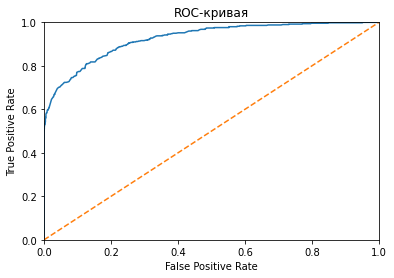

In [72]:
fpr, tpr, thresholds = roc_curve(target_basic_test, predictions_lgb)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')


plt.show()

In [73]:
basic_results = pd.DataFrame({
    'Случайный лес' : [rf_basic_score.round(4)],
    'Логистическая регрессия' : [lr_basic_score.round(4)],
    'Градиентный бустинг' : [lgb_basic_score.round(4)]
})
basic_results = basic_results.rename(index = {0 : 'roc_auc'})
basic_results

,Случайный лес,Логистическая регрессия,Градиентный бустинг
roc_auc,0.8964,0.8044,0.9259


При обучении на усеченных данных модель "Логистическая регрессия" не преодолела порог roc_auc > 0.85 на тестовой выборке, но при этом модели "Случайный лес" и "Градиентный бустинг" показали при обучении на усеченных данных даже большее значение roc-auc, чем при обучении на полных данных - 0.89 и 0.92 соответственно.

## Выводы

In [74]:
results

,Случайный лес,Логистическая регрессия,Градиентный бустинг
roc_auc,0.9078,0.8307,0.9348


In [75]:
basic_results

,Случайный лес,Логистическая регрессия,Градиентный бустинг
roc_auc,0.8964,0.8044,0.9259


В ходе решения задачи в качестве подготовительных шагов были предприняты следующие действия:

- данные были объединены из различных источников в один датафрейм
- приведены к нужному типу, добавлены необходимые признаки
- убраны наиболее коррелирующие друг с другом признаки
- отобраны наиболее значимые для определения таргета. 
- данные были разбиты на обучающую и тестовую выборки и были обучены 3 модели - "Случайный лес", "Логистическая регрессия" и "Градиентный бустинг". 

Отбор признаков для исследования проходил на основе уровня важности признаков, полученных методом "mutual_info_classif" из библиотеки sklearn.feature_selection. Приходилось пробовать разное количество признаков для обучения: было по очереди протестировано обучение моделей на 4, 5, 6, 7 самых важных признаках - этот подбор занял много времени, но дал конкретный результат - наилучшее качество модель показала на пяти признаках: "'Duration', 'Two year', 'Fiber optic', 'InternetUser', 'OneYear'"

В ходе исследования было найдено что:

Лучше всего предсказывает отток клиентов модель "Градиентный бустинг" с параметрами learning_rate=0.03, max_depth=25, n_estimators=1000 обученная на выборке с наиболее важными признаками, из чего можно сделать вывод, что остальные признаки являются избыточными и для лучшего качества необходимо запускать модель только с наиболее важными признаками. Также для стабильности работы модели имеет смысл из первоначального набора данных убирать информацию о доп. услугах - на оставшихся признаках метрики roc-auc остаются почти такими же Остальные модели также показали хороший результат (roc_auc > 0.85) кроме модели "Логистическая регрессия", обученной на базовых признаках (для логистической регрессии требуются полные данные для лучшего результата).

Итоговая модель: Градиентный бустинг, обученный на признаках: 'Duration', 'Two year', 'Fiber optic', 'InternetUser', 'OneYear' с параметрами "learning_rate=0.03, max_depth=25, n_estimators=1000". Итоговое качество: ROC-AUC 0,9344